In [1]:

import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
df = pd.read_csv("/content/drive/My Drive/Co2/GlobalTemp.csv",skiprows=4)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[:4] + '-' + df['Date'].astype(str).str[4:], format='%Y-%m')
# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)

df=df.loc[df['Date']>='2000-01-01']
df.head(2)

,Date,Anomaly
1800,2000-01-01,0.32
1801,2000-02-01,0.55


In [5]:
df1 = pd.read_csv("/content/drive/My Drive/Co2/FinalCo2.csv")
df1 = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]
df1=df1.loc[df1['Date']>='2000-01-01']
df1['ds'] = df1['Date']
df1['y'] = df1['Value']

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from prophet import Prophet


In [24]:
df['ds'] = df['Date']
df['y'] = df['Anomaly']

In [8]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.7):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative',
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['Anomaly'] = dataframe['y'].reset_index(drop = True)
    return forecast
pred1 = fit_predict_model(df1)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp44eh75sm/15bgl14v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp44eh75sm/nooor1i6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14404', 'data', 'file=/tmp/tmp44eh75sm/15bgl14v.json', 'init=/tmp/tmp44eh75sm/nooor1i6.json', 'output', 'file=/tmp/tmp44eh75sm/prophet_model89w_vbyj/prophet_model-20250418150545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
pred1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Anomaly
0,2000-01-01,368.829058,363.117689,374.847812,368.829058,368.829058,0.0,0.0,0.0,0.0,0.0,0.0,368.829058,369.45
1,2000-02-01,368.999503,363.385326,374.116783,368.999503,368.999503,0.0,0.0,0.0,0.0,0.0,0.0,368.999503,369.71
2,2000-03-01,369.158951,363.703223,374.728244,369.158951,369.158951,0.0,0.0,0.0,0.0,0.0,0.0,369.158951,370.75
3,2000-04-01,369.329395,363.737951,374.805568,369.329395,369.329395,0.0,0.0,0.0,0.0,0.0,0.0,369.329395,371.98
4,2000-05-01,369.494342,363.489950,375.339232,369.494342,369.494342,0.0,0.0,0.0,0.0,0.0,0.0,369.494342,371.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,2023-12-01,422.470151,417.273261,428.677894,422.470151,422.470151,0.0,0.0,0.0,0.0,0.0,0.0,422.470151,421.86
288,2024-01-01,422.680292,416.665353,428.440212,422.680292,422.680292,0.0,0.0,0.0,0.0,0.0,0.0,422.680292,422.80
289,2024-02-01,422.890434,416.758427,428.654505,422.890434,422.890434,0.0,0.0,0.0,0.0,0.0,0.0,422.890434,424.62
290,2024-03-01,423.087018,417.984741,428.836491,423.087018,423.087018,0.0,0.0,0.0,0.0,0.0,0.0,423.087018,425.38


In [10]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'Anomaly']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['Anomaly'] > forecasted['yhat_upper'], 'Anomaly'] = 1
    forecasted.loc[forecasted['Anomaly'] < forecasted['yhat_lower'], 'Anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['Anomaly'] ==1, 'importance'] = \
        (forecasted['Anomaly'] - forecasted['yhat_upper'])/forecast['Anomaly']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['Anomaly'])/forecast['Anomaly']
    return forecasted

pred1 = detect_anomalies(pred1)


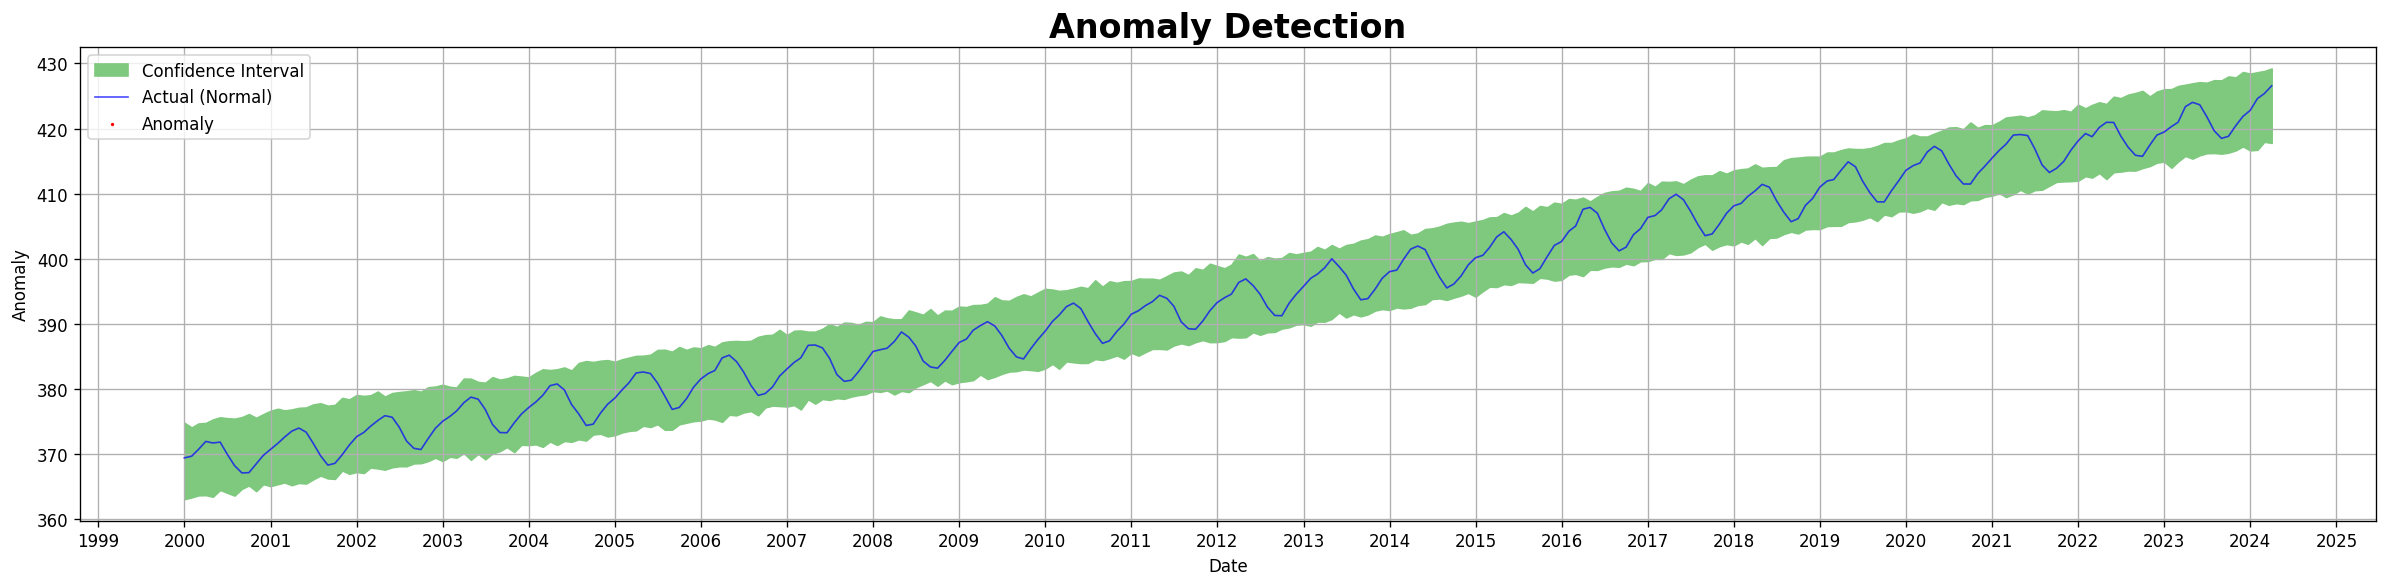

In [48]:
import matplotlib.pyplot as plt
import pandas as pd


import pandas as pd
import matplotlib.dates as mdates

def plot_anomalies_matplotlib(forecasted):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=120)

    # Ensure 'ds' is datetime
    forecasted['ds'] = pd.to_datetime(forecasted['ds'])

    # Plot confidence interval
    ax.fill_between(forecasted['ds'],
                    forecasted['yhat_lower'],
                    forecasted['yhat_upper'],
                    color='#7FC97F',
                    label='Confidence Interval')

    # Normal values
    normal = forecasted[forecasted['anomaly'] == 0]
    ax.plot(normal['ds'], normal['Anomaly'],
            label='Actual (Normal)',
            color='blue',
            linewidth=1,
            alpha=0.7)

    # Anomalies
    anomalies = forecasted[forecasted['anomaly'] != 0]
    ax.scatter(anomalies['ds'],
               anomalies['Anomaly'],
               s=anomalies['importance'] * 50,
               color='red',
               label='Anomaly')

    # Yearly ticks
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Labels and title
    ax.set_title('Anomaly Detection', fontsize=20, fontweight='bold')  # 👈 bold title
    ax.set_xlabel('Date')
    ax.set_ylabel('Anomaly')

    # Rotate x-ticks
    plt.xticks(rotation=0)

    # Legend and grid
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    plt.show()


plot_anomalies_matplotlib(pred1)

In [38]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'Anomaly']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['Anomaly'] > forecasted['yhat_upper'], 'Anomaly'] = 1
    forecasted.loc[forecasted['Anomaly'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['Anomaly'] - forecasted['yhat_upper'])/forecast['Anomaly']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['Anomaly'])/forecast['Anomaly']
    return forecasted

pred = detect_anomalies(pred)


<ipython-input-38-951d8259d6fc>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.32607875 -1.33748706]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \


In [12]:
import altair as alt

In [ ]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'Anomaly', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_line(size=1, opacity=0.7, color = 'blue').encode(
        x='ds:T',
        y=alt.Y('Anomaly', title='Anomaly'),
        tooltip=['ds', 'Anomaly', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('Anomaly', title='Anomaly'),
        tooltip=['ds', 'Anomaly', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=1200, height=450)\
              .configure_title(fontSize=20)
plot_anomalies(pred)


alt.LayerChart(...)